In [1]:
library(tidyverse)
library(RSQLite)
library(lubridate)
library(scales)
library(lmtest)
library(sandwich)

Warning message:
"package 'tidyverse' was built under R version 4.2.2"
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 1.0.0 
Warning message:
"package 'ggplot2' was built under R version 4.2.2"
Warning message:
"package 'readr' was built under R version 4.2.2"
Warning message:
"package 'purrr' was built under R version 4.2.2"
Warning message:
"package 'stringr' was built under R version 4.2.2"
Warning message:
"package 'forcats' was built under R version 4.2.2"
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
"package 'RSQLite' was built under R version 4.2.2"

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union





In [2]:
tidy_finance <- dbConnect(
  SQLite(),
  "data/tidy_finance.sqlite",
  extended_types = TRUE
)

crsp_monthly <- tbl(tidy_finance, "crsp_monthly") |>
  select(permno, month, ret_excess, mktcap_lag) |>
  collect()

factors_ff_monthly <- tbl(tidy_finance, "factors_ff_monthly") |>
  collect()

beta <- tbl(tidy_finance, "beta") |>
  collect()

In [6]:
beta_lag <- beta |>
  mutate(month = month %m+% months(1)) |>
  select(permno, month, beta_lag = beta_monthly) |>
  drop_na()

data_for_sorts <- crsp_monthly |>
  inner_join(beta_lag, by = c("permno", "month"))

In [7]:
beta_portfolios <- data_for_sorts |>
  group_by(month) |>
  mutate(
    breakpoint = median(beta_lag),
    portfolio = case_when(
      beta_lag <= breakpoint ~ "low",
      beta_lag > breakpoint ~ "high"
    )
  ) |>
  group_by(month, portfolio) |>
  summarize(ret = weighted.mean(ret_excess, mktcap_lag), breakpoint,beta_lag, .groups = "drop")

In [8]:
beta_portfolios |>
    filter(beta_lag == min(beta_lag)) 

month,portfolio,ret,breakpoint,beta_lag
<date>,<chr>,<dbl>,<dbl>,<dbl>
2018-04-01,low,0.002658321,1.013563,-13.02217


In [15]:
assign_portfolio <- function(data, var, n_portfolios) {
  breakpoints <- data |>
    summarize(breakpoint = quantile({{ var }},
      probs = seq(0, 1, length.out = n_portfolios + 1),
      na.rm = TRUE
    )) |>
    pull(breakpoint) |>
    as.numeric()

  assigned_portfolios <- data |>
    mutate(portfolio = findInterval({{ var }},
      breakpoints,
      all.inside = TRUE
    )) |>
    pull(portfolio)

  return(assigned_portfolios)
}

In [16]:
beta_portfolios <- data_for_sorts |>
  group_by(month) |>
  mutate(
    portfolio = assign_portfolio(
      data = cur_data(),
      var = beta_lag,
      n_portfolios = 10
    ),
    portfolio = as.factor(portfolio)
  ) |>
  group_by(portfolio, month) |>
  summarize(
    ret = weighted.mean(ret_excess, mktcap_lag),
    .groups = "drop"
  )

In [17]:
beta_portfolios_summary <- beta_portfolios |>
  left_join(factors_ff_monthly, by = "month") |>
  group_by(portfolio) |>
  summarize(
    alpha = as.numeric(lm(ret ~ 1 + mkt_excess)$coefficients[1]),
    beta = as.numeric(lm(ret ~ 1 + mkt_excess)$coefficients[2]),
    ret = mean(ret)
  )

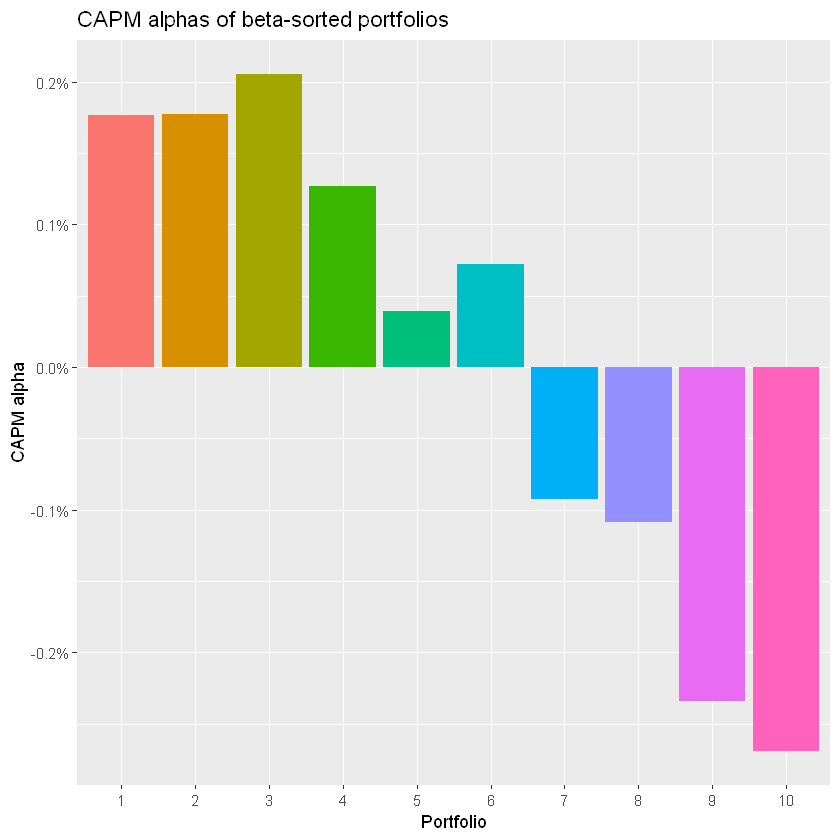

In [18]:
beta_portfolios_summary |>
  ggplot(aes(x = portfolio, y = alpha, fill = portfolio)) +
  geom_bar(stat = "identity") +
  labs(
    title = "CAPM alphas of beta-sorted portfolios",
    x = "Portfolio",
    y = "CAPM alpha",
    fill = "Portfolio"
  ) +
  scale_y_continuous(labels = percent) +
  theme(legend.position = "None")

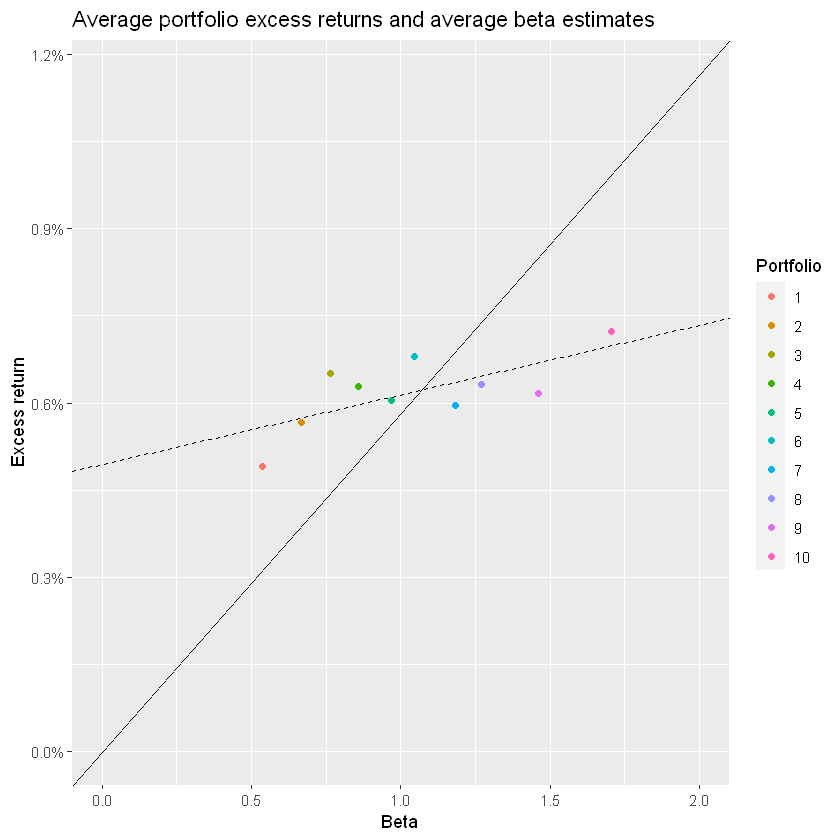

In [19]:
sml_capm <- lm(ret ~ 1 + beta, data = beta_portfolios_summary)$coefficients

beta_portfolios_summary |>
  ggplot(aes(
    x = beta, 
    y = ret, 
    color = portfolio
  )) +
  geom_point() +
  geom_abline(
    intercept = 0,
    slope = mean(factors_ff_monthly$mkt_excess),
    linetype = "solid"
  ) +
  geom_abline(
    intercept = sml_capm[1],
    slope = sml_capm[2],
    linetype = "dashed"
  ) +
  scale_y_continuous(
    labels = percent,
    limit = c(0, mean(factors_ff_monthly$mkt_excess) * 2)
  ) +
  scale_x_continuous(limits = c(0, 2)) +
  labs(
    x = "Beta", y = "Excess return", color = "Portfolio",
    title = "Average portfolio excess returns and average beta estimates"
  )

In [20]:
beta_longshort <- beta_portfolios |>
  ungroup() |>
  mutate(portfolio = case_when(
    portfolio == max(as.numeric(portfolio)) ~ "high",
    portfolio == min(as.numeric(portfolio)) ~ "low"
  )) |>
  filter(portfolio %in% c("low", "high")) |>
  pivot_wider(month, names_from = portfolio, values_from = ret) |>
  mutate(long_short = high - low) |>
  left_join(factors_ff_monthly, by = "month")

In [21]:
coeftest(lm(long_short ~ 1 + mkt_excess, data = beta_longshort),
  vcov = NeweyWest
)


t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0044585  0.0025579 -1.7431  0.08177 .  
mkt_excess   1.1656235  0.0956228 12.1898  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


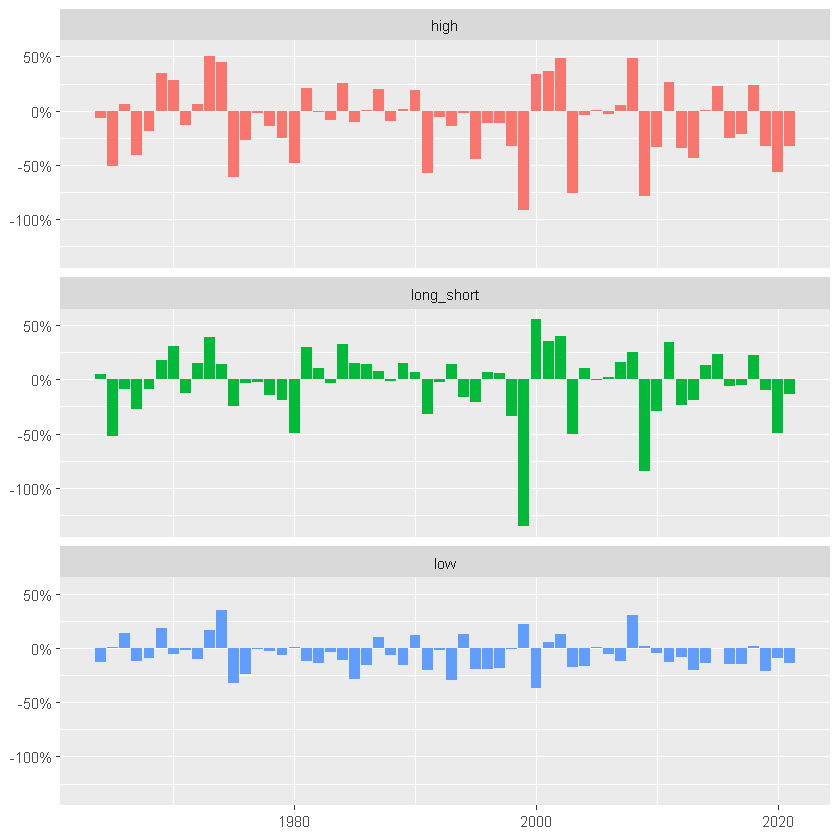

In [24]:
beta_longshort |>
  group_by(year = year(month)) |>
  summarize(
    low = prod(1 + low),
    high = prod(1 + high),
    long_short = prod(1 + long_short)
  ) |>
  pivot_longer(cols = -year) |>
  ggplot(aes(x = year, y = 1 - value, fill = name)) +
  geom_col(position = "dodge") +
  facet_wrap(~name, ncol = 1) +
  theme(legend.position = "none") +
  scale_y_continuous(labels = percent) +
  labs(
    #title = "",
    x = NULL, y = NULL
  )